In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
# Listing the files inside the Google Drive directory (Use your own directory)
!ls "/content/gdrive/MyDrive/CS464/dataset"

test  train  train_aug


In [ ]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random
import tensorflow as tf
from sklearn.utils import resample
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import RandomOverSampler

In [ ]:
img_size = 48 #original size of the image

In [ ]:
def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count("/content/gdrive/MyDrive/CS464/dataset/train", 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count("/content/gdrive/MyDrive/CS464/dataset/test", 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,4005,958
surprise,3171,831
disgust,436,111


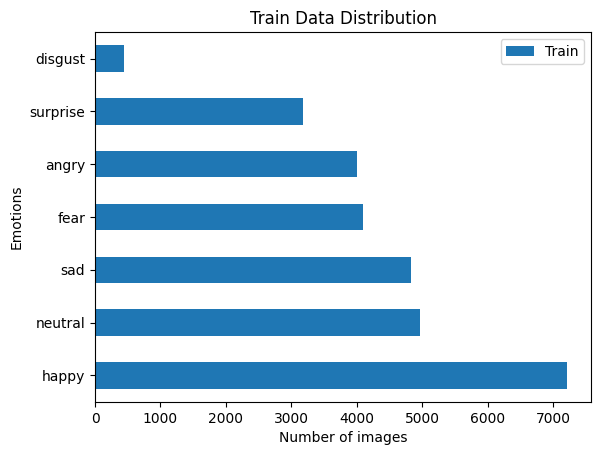

In [ ]:
Train_Count.plot(kind='barh')
plt.title('Train Data Distribution')
plt.xlabel('Number of images')
plt.ylabel('Emotions')
plt.show()

<Axes: >

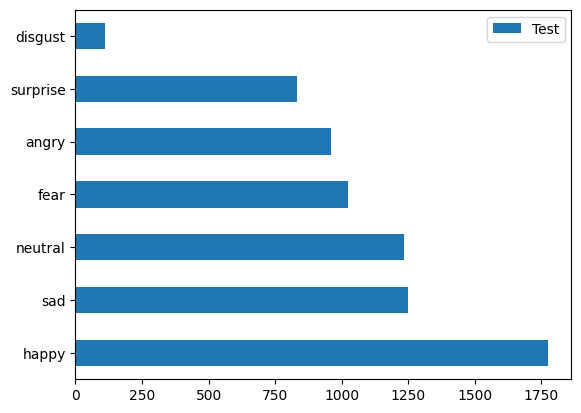

In [ ]:
Test_Count.plot(kind='barh')

Unbalanced Data
Classification model favours the majority class due to its larger volume presence. Hence, accuracy of the model decreases.

Possible Solutions
Resampling (Undersampling or Oversampling)
SMOTE (Synthetic Minority Oversampling Technique)

In [ ]:
def getFaceImages(emotions, data_type, print_n=False):
    images = []
    labels = []
    path = "/content/gdrive/MyDrive/CS464/dataset/" + data_type + "/"
    for i,f in enumerate(emotions):
        p = path + f
        j=0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (img_size, img_size))
            images.append(image)
            labels.append(i)
            j+=1
        if(print_n):
            print("There are " , j , " " , data_type.upper(), " images of " , emotions[i].upper())
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#Get Images and Labels
X, y =  getFaceImages(emotions, 'train', print_n=True)

# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test = getFaceImages(emotions, 'test', print_n=True)

There are  4005   TRAIN  images of  ANGRY
There are  436   TRAIN  images of  DISGUST
There are  4097   TRAIN  images of  FEAR
There are  7215   TRAIN  images of  HAPPY
There are  4965   TRAIN  images of  NEUTRAL
There are  4830   TRAIN  images of  SAD
There are  3171   TRAIN  images of  SURPRISE
There are  958   TEST  images of  ANGRY
There are  111   TEST  images of  DISGUST
There are  1024   TEST  images of  FEAR
There are  1774   TEST  images of  HAPPY
There are  1233   TEST  images of  NEUTRAL
There are  1247   TEST  images of  SAD
There are  831   TEST  images of  SURPRISE


In [ ]:
#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_train])
X_val = scaler.fit_transform([i.flatten() for i in X_val])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

In [ ]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

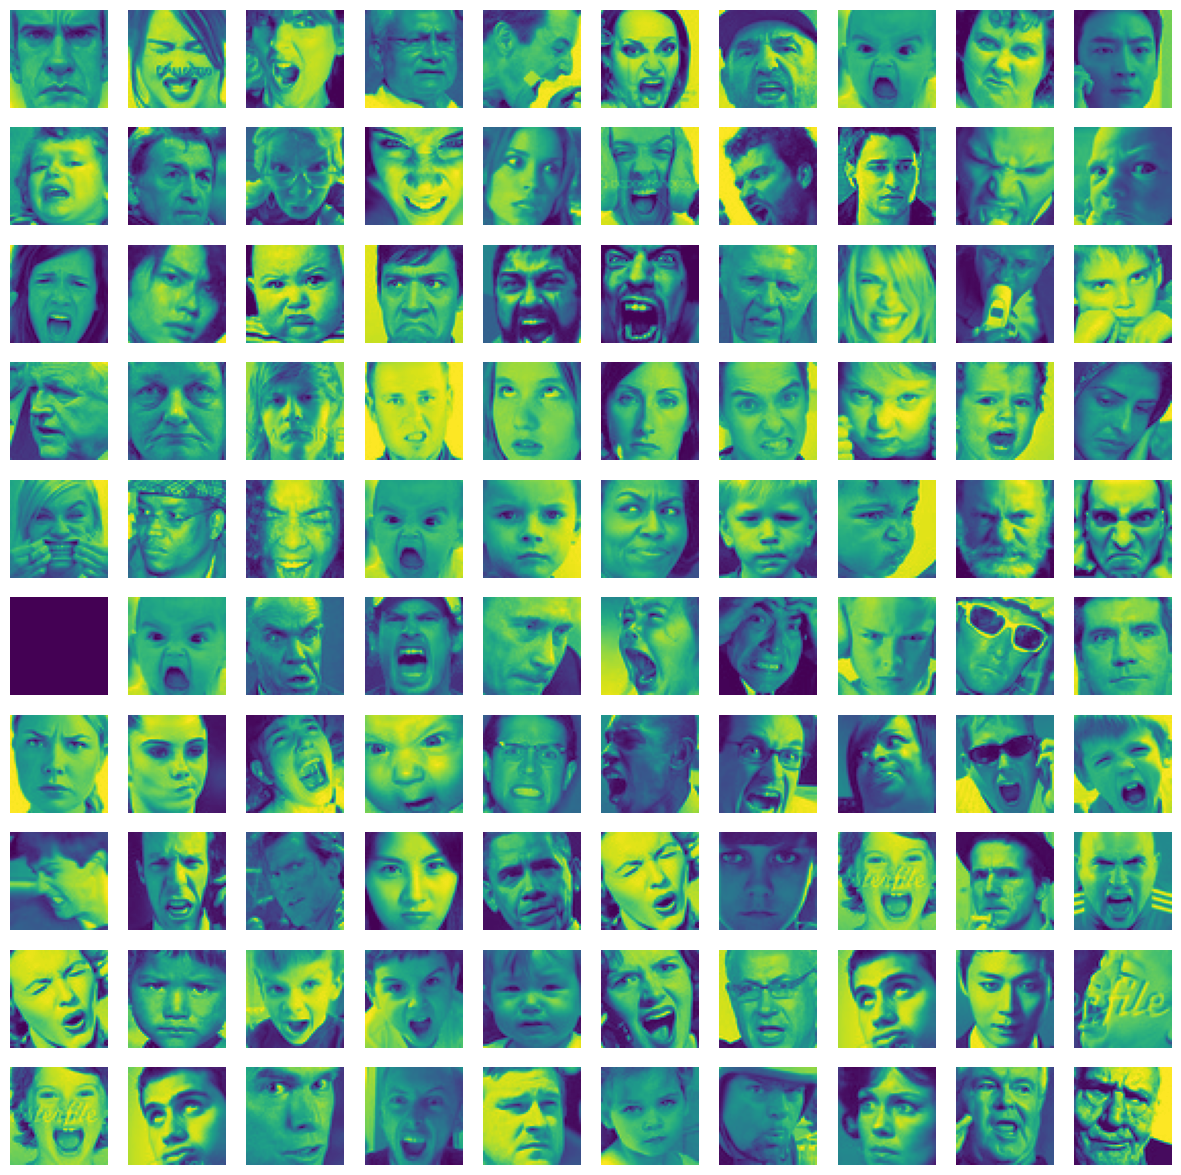

In [ ]:
plot_image_grid(X[0:100], 10, 10)

PCA - Explained Variance Analysis

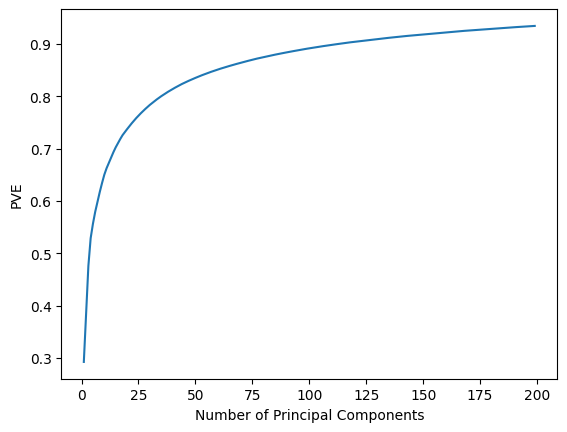

In [ ]:
number_of_components = [x for x in range(1,200)]
pve_list=[]
for component in number_of_components:
      pca = PCA(n_components=component)
      pca.fit(X_train)
      pve_list.append(np.sum(pca.explained_variance_ratio_))


plt.plot(number_of_components, pve_list)
plt.xlabel("Number of Principal Components")
plt.ylabel("PVE")
plt.show()

In [ ]:
pca100 = PCA(n_components=100)
X_train100 = pca100.fit_transform(X_train)
X_test100 = pca100.fit_transform(X_test)

pca200 = PCA(n_components=200)
X_train200 = pca200.fit_transform(X_train)
X_test200 = pca200.fit_transform(X_test)




In [ ]:
X_val100 = pca100.fit_transform(X_val)
X_val200 = pca200.fit_transform(X_val)



In [ ]:

# Initialize k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Fit k-NN on the training data with 100 principal components
knn.fit(X_train100, y_train)
# Predict on the validation set with 100 principal components
y_pred100 = knn.predict(X_val100)

# Evaluate the model with 100 principal components
precision100 = metrics.accuracy_score(y_pred100, y_val) * 100
print("Accuracy with 5-NN on 100 principal components: {0:.2f}%".format(precision100))

# Now do the same for the training data with 200 principal components
knn.fit(X_train200, y_train)
y_pred200 = knn.predict(X_val200)

# Evaluate the model with 200 principal components
precision200 = metrics.accuracy_score(y_pred200, y_val) * 100
print("Accuracy with 5-NN on 200 principal components: {0:.2f}%".format(precision200))

Accuracy with 5-NN on 100 principal components: 18.80%
Accuracy with 5-NN on 200 principal components: 18.47%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_val) * 100
print("Accuracy with 2-NN: {0:.2f}%".format(precision))

Accuracy with 2-NN: 33.46%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_val) * 100
print("Accuracy with 5-NN: {0:.2f}%".format(precision))

Accuracy with 5-NN: 33.69%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_val) * 100
print("Accuracy with 10-NN: {0:.2f}%".format(precision))

Accuracy with 10-NN: 32.45%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_val) * 100
print("Accuracy with 15-NN: {0:.2f}%".format(precision))

Accuracy with 15-NN: 32.19%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with 2-NN: {0:.2f}%".format(precision))
conf_matrix = metrics.confusion_matrix(y_pred, y_test)
print(conf_matrix)

Accuracy with 2-NN: 33.66%
[[355  19 192 296 192 245 104]
 [ 24  58  23  51  29  49  13]
 [160  10 403 256 225 213 130]
 [213  10 188 797 320 328 148]
 [147  12 139 289 390 250 120]
 [ 42   2  55  65  62 152  55]
 [ 17   0  24  20  15  10 261]]


In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with 3-NN: {0:.2f}%".format(precision))
conf_matrix = metrics.confusion_matrix(y_pred, y_test)
print(conf_matrix)

Accuracy with 3-NN: 32.67%
[[326  21 210 289 215 266 108]
 [ 22  49  20  59  27  43  19]
 [144  14 337 228 211 218 129]
 [202  11 167 715 257 241 127]
 [163  12 154 323 389 247  96]
 [ 76   4  80 108  91 203  26]
 [ 25   0  56  52  43  29 326]]


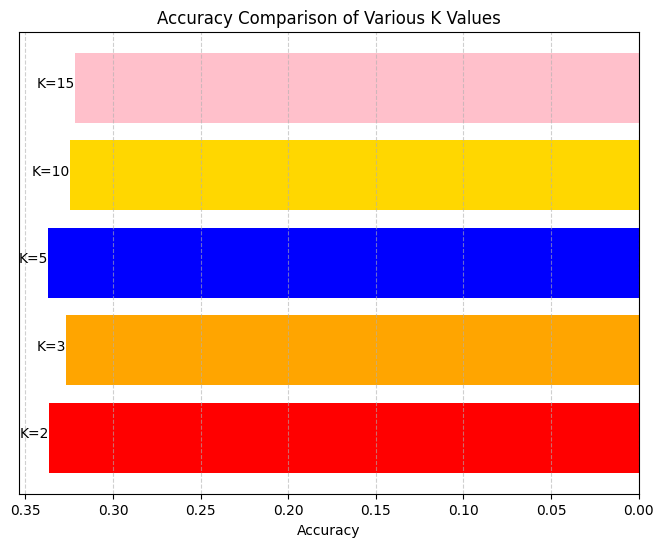

In [ ]:
models = ['K=2', 'K=3', 'K=5', 'K=10', 'K=15', ]
accuracy = [0.3366, 0.3267,0.3369, 0.3245, 0.3219]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a horizontal bar graph with colors
bars = ax.barh(models, accuracy, color=['red','orange' , 'blue','gold', 'pink' ])

# Add data values and model names on top of the bars
for bar, model in zip(bars, models):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, model, ha='right', va='baseline', color='black', fontsize=10)

# Add labels and title
plt.xlabel('Accuracy')
plt.title('Accuracy Comparison of Various K Values')

# Remove the y-axis label
ax.yaxis.set_visible(False)

# Add a grid for better readability
ax.xaxis.grid(True, linestyle='--', alpha=0.6)

# Invert the x-axis for better visual appeal
ax.invert_xaxis()

# Show the graph
plt.show()


### SMOTE

In [ ]:

from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('Dataset shape %s' ,y_train.shape)

print('Resampled dataset shape %s' ,y_train_resampled.shape)


Dataset shape %s (22975,)
Resampled dataset shape %s (40320,)


In [ ]:
# Convert the resampled data to a DataFrame for visualization (optional)
resampled_data = pd.DataFrame(data=X_train_resampled)

# Add a column for the labels
resampled_data['label'] = y_train_resampled



          0         1         2         3         4         5         6  \
0 -0.690061 -0.539929 -0.360651 -0.170988 -0.053436 -0.032020  0.035508   
1  1.624659  1.679252  1.753434  1.821762  1.881880  1.936558  2.016842   
2  1.624659  1.642265  1.740924  1.808988  0.600387 -1.130138 -1.440245   
3  0.170385  0.150483  0.039649 -0.094344 -0.275736 -0.554296 -0.811683   
4  0.012838  0.101167  0.177253  0.237781  0.312705  0.356339  0.404446   

          7         8         9  ...      2295      2296      2297      2298  \
0  0.081838  0.087977  0.110282  ...  0.725987  0.732673  0.690277  0.684646   
1  2.066981  2.050956  2.102059  ... -0.439978 -0.501271 -0.456173 -0.484433   
2 -1.400028 -1.362921 -1.304168  ... -0.973793  0.413789  1.973208  1.880601   
3 -0.938693 -0.822390 -0.799007  ...  0.599557  0.580163  0.581091  0.550269   
4  0.445315  0.472038  0.499977  ...  0.459079  0.496976  0.512850  0.536832   

       2299      2300      2301      2302      2303  label  
0  0.66

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_val)
#Evaluation
precision = metrics.accuracy_score(y_val, y_pred) * 100
print("Accuracy with 2-NN (after smote): {0:.2f}%".format(precision))
conf_matrix = metrics.confusion_matrix(y_val, y_pred)
print(conf_matrix)

In [ ]:
# Create and train the KNN classifier on the resampled dataset
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled, y_train_resampled)
# Predict using the KNN classifier on the validation set
y_pred = knn.predict(X_val)
# Evaluate the accuracy
accuracy = metrics.accuracy_score(y_val, y_pred) * 100
print("Accuracy with SMOTE and 5-NN: {:.2f}%".format(accuracy))

Accuracy with SMOTE and 5-NN: 28.10%


In [ ]:
# Create and train the KNN classifier on the resampled dataset
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_resampled, y_train_resampled)
# Predict using the KNN classifier on the validation set
y_pred = knn.predict(X_val)
# Evaluate the accuracy
accuracy = metrics.accuracy_score(y_val, y_pred) * 100
print("Accuracy with SMOTE and 15-NN: {:.2f}%".format(accuracy))

Accuracy with SMOTE and 15-NN: 23.24%


In [ ]:
# Create and train the KNN classifier on the resampled dataset
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_resampled, y_train_resampled)
# Predict using the KNN classifier on the validation set
y_pred = knn.predict(X_val)
# Evaluate the accuracy
accuracy = metrics.accuracy_score(y_val, y_pred) * 100
print("Accuracy with SMOTE and 10-NN: {:.2f}%".format(accuracy))
conf_matrix = metrics.confusion_matrix(y_val, y_pred)
print(conf_matrix)

NameError: ignored

### Data Augmentation Preprocessing

In [ ]:


# Define the augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directory paths to your dataset
train_data_dir = "/content/gdrive/MyDrive/CS464/dataset"

# Function to perform data augmentation to create 3000 images for a class if *_augmented directory doesn't exist
def augment_class(class_name):
    print(class_name)
    # Set up a directory for the augmented images
    output_dir = f'{train_data_dir}/train_aug/{class_name}'

    # Check if the *_augmented directory already exists
    if not os.path.exists(output_dir):
        # Create the directory if it doesn't exist
        os.makedirs(output_dir)

        # Select images belonging to the specific class
        class_images = os.listdir(f'{train_data_dir}/train/{class_name}')

        # Shuffle the images to randomize selection
        random.shuffle(class_images)

        # Ensure exactly 3000 augmented images are created for each class
        images_needed = 3000
        images_per_original = (images_needed + len(class_images) - 1) // len(class_images)

        total_images_created = 0
        for img_name in class_images:
            if total_images_created >= images_needed:
                break

            img_path = f'{train_data_dir}/train/{class_name}/{img_name}'
            img = load_img(img_path, color_mode='rgb', target_size=(48, 48))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix=f'{class_name}aug{i}', save_format='jpg'):
                i += 1
                total_images_created += 1
                print(total_images_created)
                if i >= images_per_original:
                    break

# Apply augmentation to each class that has fewer than 3000 images or select 3000 if more than 3000 exist
classes_to_augment = ['angry', 'disgust', 'fear', 'neutral', 'sad', 'surprise', 'happy']

for class_name in classes_to_augment:
    augment_class(class_name)

angry
disgust
fear
neutral
sad
surprise
happy


In [ ]:
emotions = ['angry','disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#Get Images and Labels
X_aug, y_aug =  getFaceImages(emotions, 'train_aug', print_n=True)

# Splitting the data into train and validation sets
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

There are  2580   TRAIN_AUG  images of  ANGRY
There are  2597   TRAIN_AUG  images of  DISGUST
There are  2586   TRAIN_AUG  images of  FEAR
There are  2586   TRAIN_AUG  images of  HAPPY
There are  2573   TRAIN_AUG  images of  NEUTRAL
There are  2595   TRAIN_AUG  images of  SAD
There are  2605   TRAIN_AUG  images of  SURPRISE


In [ ]:
X_train_flatten_def = np.array([i.flatten() for i in X_train])
X_test_flatten = np.array([i.flatten() for i in X_test])

In [ ]:
X_train_flatten_aug = np.array([i.flatten() for i in X_train_aug])

In [ ]:
classifier_aug = KNeighborsClassifier(n_neighbors=5)
classifier_aug.fit(X_train_flatten_aug,y_train_aug)

KNeighborsClassifier()

In [ ]:
y_pred_aug = classifier_aug.predict(X_test_flatten)
cm = metrics.confusion_matrix(y_test, y_pred_aug)
print(cm)
print("Accuracy with Data Augmentation and 10-NN:")
metrics.accuracy_score(y_test, y_pred_aug)

[[ 958    0    0    0    0    0    0]
 [ 111    0    0    0    0    0    0]
 [1024    0    0    0    0    0    0]
 [1774    0    0    0    0    0    0]
 [1233    0    0    0    0    0    0]
 [1247    0    0    0    0    0    0]
 [ 831    0    0    0    0    0    0]]
Accuracy with Data Augmentation and 10-NN:


0.13346336026748398

## Resample Preprocessing

In [ ]:
# Print the class distribution before resampling
print("Class distribution before resampling:")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
# Combine X_train and y_train for resampling
train_data = np.column_stack((X_train_flatten_def, y_train))
# Initialize variables to store upsampled data
upsampled_data = []

# Identify the class with the maximum samples
majority_class_label = unique[np.argmax(counts)]

# Upsample each minority class to match the size of the majority class
for label in unique:
    if label != majority_class_label:
        minority_class = train_data[train_data[:, -1] == label]
        minority_upsampled = resample(minority_class, replace=True, n_samples=counts.max(), random_state=42)
        upsampled_data.append(minority_upsampled)

# Combine the upsampled minority classes with the majority class
combined_data = np.vstack([train_data[train_data[:, -1] == majority_class_label]] + upsampled_data)

# Separate features and labels after resampling
X_resampled = combined_data[:, :-1]
y_resampled = combined_data[:, -1]

# Print the class distribution after resampling
print("\nClass distribution after resampling:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))

Class distribution before resampling:
{0: 3227, 1: 345, 2: 3260, 3: 5760, 4: 4007, 5: 3844, 6: 2532}

Class distribution after resampling:
{0.0: 5760, 1.0: 5760, 2.0: 5760, 3.0: 5760, 4.0: 5760, 5.0: 5760, 6.0: 5760}


In [ ]:
classifier_res = KNeighborsClassifier(n_neighbors=5)
classifier_res.fit(X_resampled,y_resampled)

KNeighborsClassifier()

In [ ]:
y_pred_res = classifier_res.predict(X_test_flatten)
cm = metrics.confusion_matrix(y_test, y_pred_res)
print(cm)
print("Accuracy with Resampling and 10-NN:")

metrics.accuracy_score(y_test, y_pred_res)

[[260  42 139 131 219 103  64]
 [  4  64  10   5  15  10   3]
 [155  29 295 119 190 131 105]
 [255  90 207 460 447 188 127]
 [163  38 152 163 454 162 101]
 [209  68 185 136 304 259  86]
 [ 78  21 105  61 117  61 388]]
Accuracy with Resampling and 10-NN:


0.3037057676232934

## Balanced Bagging Classification

In [ ]:
classifier_BBC = KNeighborsClassifier(n_neighbors=5)
balanced_bagging_clf = BalancedBaggingClassifier(classifier_BBC,
                                                 n_estimators=50,
                                                 sampling_strategy='auto',  # 'auto' uses the inverse of class frequencies
                                                 random_state=42)
balanced_bagging_clf.fit(X_train.reshape(-1, 48 * 48), y_train)

BalancedBaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=50,
                          random_state=42)

In [ ]:
y_pred_BBC = balanced_bagging_clf.predict(X_test_flatten)
cm = metrics.confusion_matrix(y_test, y_pred_BBC)
print(cm)
print("Accuracy with BBC and 10-NN:")
metrics.accuracy_score(y_test, y_pred_BBC)

[[114 255  54 131 262  66  76]
 [  2  77   1   6  19   3   3]
 [ 65 250 131 140 233  73 132]
 [ 79 511  64 500 448  87  85]
 [ 63 327  50 164 480  71  78]
 [ 95 371  67 110 372 182  50]
 [ 26 202  60  85 150  36 272]]


0.24463638896628587

## RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train.reshape(-1, 48 * 48), y_train)

In [ ]:
print('Dataset shape %s' ,y_train.shape)

print('Resampled dataset shape %s' ,y_res)

In [ ]:
classifier_res = KNeighborsClassifier(n_neighbors=5)
classifier_res.fit(X_res,y_res)

KNeighborsClassifier()

In [ ]:
y_pred_res = classifier_res.predict(X_test_flatten)
cm = metrics.confusion_matrix(y_test, y_pred_res)
print(cm)
print("Accuracy with RandomOverSampler and 10-NN:")
metrics.accuracy_score(y_test, y_pred_res)

SyntaxError: ignored

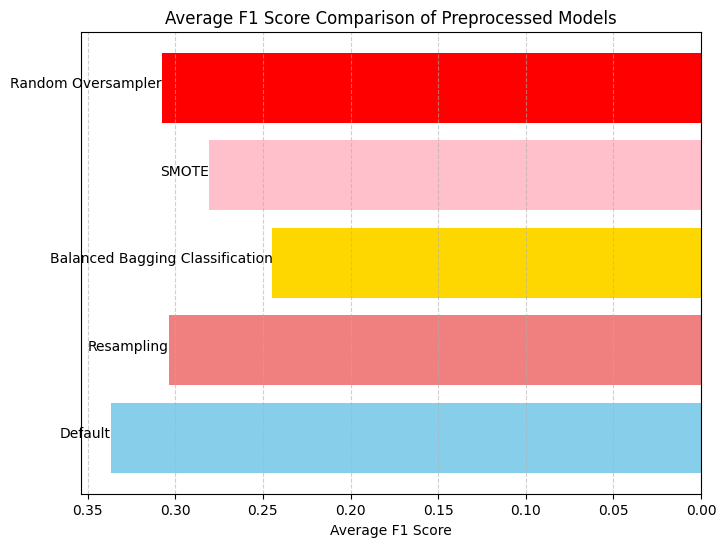

In [ ]:
models = ['Default',  'Resampling', 'Balanced Bagging Classification', 'SMOTE', 'Random Oversampler']
accuracy = [0.3369, 0.3037, 0.2446, 0.2810, 0.3078]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a horizontal bar graph with colors
bars = ax.barh(models, accuracy, color=['skyblue', 'lightcoral','gold', 'pink','red' ])

# Add data values and model names on top of the bars
for bar, model in zip(bars, models):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, model, ha='right', va='baseline', color='black', fontsize=10)

# Add labels and title
plt.xlabel('Average F1 Score')
plt.title('Average F1 Score Comparison of Preprocessed Models')

# Remove the y-axis label
ax.yaxis.set_visible(False)

# Add a grid for better readability
ax.xaxis.grid(True, linestyle='--', alpha=0.6)

# Invert the x-axis for better visual appeal
ax.invert_xaxis()

# Show the graph
plt.show()


In [ ]:
import numpy as np

# Confusion matrix
confusion_matrix = np.array([[114, 255 , 54, 131 ,262 , 66 , 76],
 [  2 , 77 ,  1  ,6 , 19  , 3,   3],
 [ 65 ,250,131 ,140, 233 , 73 ,132],
 [ 79 ,511 , 64 ,500, 448 , 87 , 85],
 [ 63 ,327 , 50, 164, 480 , 71,  78],
 [ 95 ,371 , 67 ,110 ,372, 182 , 50],
 [ 26, 202 , 60 , 85 ,150 , 36 ,272]])

# Function to calculate precision, recall, and F1 score
def calculate_metrics(conf_matrix):
    precision = []
    recall = []
    f1_scores = []

    for i in range(conf_matrix.shape[0]):
        true_positives = conf_matrix[i, i]
        false_positives = np.sum(conf_matrix[:, i]) - true_positives
        false_negatives = np.sum(conf_matrix[i, :]) - true_positives

        precision_i = true_positives / (true_positives + false_positives + 1e-15)
        recall_i = true_positives / (true_positives + false_negatives + 1e-15)

        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i + 1e-15)

        precision.append(precision_i)
        recall.append(recall_i)
        f1_scores.append(f1_score_i)

    return precision, recall, f1_scores

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_scores = calculate_metrics(confusion_matrix)

# Calculate average F1 score
average_f1_score = np.mean(f1_scores)

print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1 Scores for each class:", f1_scores)
print("Average F1 Score for BBC:", average_f1_score)

Precision for each class: [0.25675675675675674, 0.0386352232814852, 0.30679156908665106, 0.44014084507042256, 0.24439918533604887, 0.35135135135135137, 0.39080459770114945]
Recall for each class: [0.11899791231732777, 0.6936936936936937, 0.1279296875, 0.2818489289740699, 0.38929440389294406, 0.14595028067361668, 0.32731648616125153]
F1 Scores for each class: [0.16262482168330913, 0.07319391634980979, 0.18056512749827663, 0.3436426116838483, 0.30028151391929886, 0.20623229461756334, 0.35625409299279587]
Average F1 Score for BBC: 0.23182776839212885


In [ ]:
# Confusion matrix
confusion_matrix = np.array([])


# Calculate precision, recall, and F1 score for each class
precision, recall, f1_scores = calculate_metrics(confusion_matrix)

# Calculate average F1 score
average_f1_score = np.mean(f1_scores)

print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1 Scores for each class:", f1_scores)
print("Average F1 Score for Random Oversampling:", average_f1_score)

Precision for each class: [0.25675675675675674, 0.0386352232814852, 0.30679156908665106, 0.44014084507042256, 0.24439918533604887, 0.35135135135135137, 0.39080459770114945]
Recall for each class: [0.11899791231732777, 0.6936936936936937, 0.1279296875, 0.2818489289740699, 0.38929440389294406, 0.14595028067361668, 0.32731648616125153]
F1 Scores for each class: [0.16262482168330913, 0.07319391634980979, 0.18056512749827663, 0.3436426116838483, 0.30028151391929886, 0.20623229461756334, 0.35625409299279587]
Average F1 Score for Random Oversampling: 0.23182776839212885


In [ ]:
# Confusion matrix
confusion_matrix = np.array([[260,  42 ,139, 131 ,219 ,103,  64],
 [  4  ,64,  10 , 5  ,15,  10 ,  3],
 [155 , 29 ,295 ,119 ,190, 131, 105],
 [255 , 90 ,207 ,460, 447, 188 ,127],
 [163 , 38, 152, 163 ,454, 162 ,101],
 [209 , 68 ,185 ,136 ,304 ,259 , 86],
 [ 78 , 21, 105 , 61, 117,  61, 388]])


# Calculate precision, recall, and F1 score for each class
precision, recall, f1_scores = calculate_metrics(confusion_matrix)

# Calculate average F1 score
average_f1_score = np.mean(f1_scores)

print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1 Scores for each class:", f1_scores)
print("Average F1 Score for  resampling:", average_f1_score)

Precision for each class: [0.2313167259786477, 0.18181818181818182, 0.2698993595608417, 0.42790697674418604, 0.2600229095074456, 0.2833698030634573, 0.4439359267734554]
Recall for each class: [0.27139874739039666, 0.5765765765765766, 0.2880859375, 0.2593010146561443, 0.3682076236820762, 0.20769847634322375, 0.46690734055354993]
F1 Scores for each class: [0.24975984630163256, 0.27645788336933014, 0.2786962683042036, 0.3229203229203224, 0.3048002685464916, 0.23970384081443727, 0.4551319648093837]
Average F1 Score for  resampling: 0.30392434215225733


In [ ]:
# Confusion matrix
confusion_matrix = np.array([])


# Calculate precision, recall, and F1 score for each class
precision, recall, f1_scores = calculate_metrics(confusion_matrix)

# Calculate average F1 score
average_f1_score = np.mean(f1_scores)

print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1 Scores for each class:", f1_scores)
print("Average F1 Score for SMOTE:", average_f1_score)